# CS7250

# Download Dataset

In [ ]:
# download the dataset from the official website

!gdown 'https://drive.google.com/uc?id=16IOvrVM6DdVyg4e2XEFffJsjL9IHCOqV' --output /content/cifar-10-python.tar.gz
!tar -xzf /content/cifar-10-python.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=16IOvrVM6DdVyg4e2XEFffJsjL9IHCOqV
From (redirected): https://drive.google.com/uc?id=16IOvrVM6DdVyg4e2XEFffJsjL9IHCOqV&confirm=t&uuid=a4177829-8f51-4cc4-a8e2-36fd445506df
To: /content/cifar-10-python.tar.gz
100% 775M/775M [00:07<00:00, 105MB/s]


In [ ]:
# download the checkpoints
!gdown 'https://drive.google.com/uc?id=1uBCAJ7OAhHVz3JT0QXbligl-b67_WGqL' --output /content/CNN.pth
!gdown 'https://drive.google.com/uc?id=1ih64sIyw6wR3dY-aYzYsGXkm-YQpDCYJ' --output /content/D2.pth
!gdown 'https://drive.google.com/uc?id=12qVV0cEBKlS8-RieEuRDrW4ZYqCPscBf' --output /content/D4.pth

Downloading...
From (original): https://drive.google.com/uc?id=1uBCAJ7OAhHVz3JT0QXbligl-b67_WGqL
From (redirected): https://drive.google.com/uc?id=1uBCAJ7OAhHVz3JT0QXbligl-b67_WGqL&confirm=t&uuid=d0640914-e66b-465b-a891-c3f4f4115f3c
To: /content/CNN.pth
100% 46.8M/46.8M [00:00<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ih64sIyw6wR3dY-aYzYsGXkm-YQpDCYJ
To: /content/D2.pth
100% 16.4M/16.4M [00:00<00:00, 82.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=12qVV0cEBKlS8-RieEuRDrW4ZYqCPscBf
From (redirected): https://drive.google.com/uc?id=12qVV0cEBKlS8-RieEuRDrW4ZYqCPscBf&confirm=t&uuid=dc787340-8309-4946-bd23-ae005906270b
To: /content/D4.pth
100% 59.8M/59.8M [00:00<00:00, 138MB/s]


# Download the required dependencies

In [ ]:
!pip install e2cnn
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Build the Equivariant Network

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
# define model
from e2cnn import gspaces
from e2cnn import nn
import torch
import torch.nn.functional as F
from einops import rearrange

def conv2d(feat_type_in, feat_type_hid, kernel_size, stride=1, groups=1, dilation=1, initialize=False):
    return nn.R2Conv(feat_type_in, feat_type_hid, kernel_size=kernel_size, stride=stride, dilation=dilation,
                     padding=(kernel_size - 1) // 2, groups=groups, initialize=initialize)


class EquiBasicBlock(torch.nn.Module):
    def __init__(self, in_planes, out_planes, flip=False, quotient=False, N=4, initialize=True, stride=1,
                 down_sample=None, dilation=1, kernel_size=3, norm_layer=None):
        super(EquiBasicBlock, self).__init__()
        if flip:
            r2_act = gspaces.FlipRot2dOnR2(N=N)
        else:
            r2_act = gspaces.Rot2dOnR2(N=N)

        if quotient:
            if flip:
                rep = r2_act.quotient_repr((None, 2))
            else:
                rep = r2_act.quotient_repr(2)
        else:
            rep = r2_act.regular_repr

        feat_type_in = nn.FieldType(r2_act, [rep] * in_planes)
        feat_type_hid = nn.FieldType(r2_act, [rep] * out_planes)

        self.conv1 = conv2d(feat_type_in, feat_type_hid, kernel_size=kernel_size, initialize=initialize,
                            dilation=dilation)

        self.conv2 = conv2d(feat_type_hid, feat_type_hid, kernel_size=kernel_size, initialize=initialize,
                            dilation=dilation)

        self.relu = nn.ReLU(feat_type_hid)

        self.down_sample = down_sample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.down_sample is not None:
            identity = self.down_sample(identity)

        out += identity
        out = self.relu(out)

        return out


class ResNet_18(torch.nn.Module):
    def __init__(self, block, layers, flip=False, quotient=False, N=4, initialize=True, insize=3):
        super(ResNet_18, self).__init__()
        self.N = N
        self.quotient = quotient
        if flip:
            self.r2_act = gspaces.FlipRot2dOnR2(N=N)
        else:
            self.r2_act = gspaces.Rot2dOnR2(N=N)

        if quotient:
            if flip:
                self.repr = self.r2_act.quotient_repr((None, 2))
            else:
                self.repr = self.r2_act.quotient_repr(2)
        else:
            self.repr = self.r2_act.regular_repr

        self.in_planes = 4

        feat_type_in = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr] * insize)
        feat_type_hid = nn.FieldType(self.r2_act, [self.repr] * self.in_planes)

        self.conv1 = nn.R2Conv(feat_type_in, feat_type_hid,
                               kernel_size=3, stride=1, padding=1, initialize=initialize)

        self.conv2 = nn.R2Conv(feat_type_hid, feat_type_hid,
                               kernel_size=3, stride=1, padding=1, initialize=initialize)
        self.relu = nn.ReLU(feat_type_hid)

        self.maxpool = nn.PointwiseMaxPool(feat_type_hid, kernel_size=2, stride=2, padding=0, ceil_mode=True)

        self.layer1 = self._make_layer(block, 8, layers[0], stride=1, flip=flip, N=N, initialize=initialize,
                                       quotient=quotient)
        self.layer2 = self._make_layer(block, 16, layers[1], stride=1, flip=flip, N=N, initialize=initialize,
                                       quotient=quotient, pool=True)
        self.layer3 = self._make_layer(block, 32, layers[2], stride=1, flip=flip, N=N, initialize=initialize,
                                       quotient=quotient, pool=True)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=1, flip=flip, N=N, initialize=initialize,
                                       quotient=quotient, pool=True)

    def _make_layer(self, block, out_planes, block_num, stride=1, flip=True, N=4, initialize=True, quotient=False,
                    pool=False):
        down_sample = None
        if self.in_planes != out_planes:
            down_sample = nn.SequentialModule(
                nn.R2Conv(nn.FieldType(self.r2_act, [self.repr] * self.in_planes),
                          nn.FieldType(self.r2_act, [self.repr] * out_planes),
                          kernel_size=1, stride=stride, initialize=initialize),
            )
        if pool:
            layers = [nn.PointwiseMaxPool(nn.FieldType(self.r2_act, [self.repr] * self.in_planes), kernel_size=2,
                                          padding=0, ceil_mode=True)]
        else:
            layers = []

        layers.append(block(self.in_planes, out_planes, stride=1, down_sample=down_sample, flip=flip, N=N,
                            initialize=initialize, quotient=quotient))

        self.in_planes = out_planes

        for i in range(1, block_num):
            layers.append(
                block(self.in_planes, out_planes, stride=1, down_sample=None, flip=flip, N=N, initialize=initialize,
                      quotient=quotient))

        return torch.nn.Sequential(*layers)

    def forward(self, x):

        x = nn.GeometricTensor(x,
                               nn.FieldType(self.r2_act, x.shape[1] * [self.r2_act.trivial_repr]))  # [1, 3, 128, 128]
        x = self.conv1(x)  # [1, 32, 64, 64]
        feature_1 = self.relu(x)  # [1, 32, 64, 64]

        feature_1 = self.conv2(feature_1)
        feature_1 = self.relu(feature_1)  # [1, 32, 64, 64]
        # feature_1 = self.maxpool(feature_1)  # (1, 32, 32, 32)

        feature_2 = self.layer1(feature_1)  # (1, 64, 64, 64)

        feature_3 = self.layer2(feature_2)  # [1, 128, 32, 32]

        feature_4 = self.layer3(feature_3)  # [1, 256, 16, 16]
        feature_5 = self.layer4(feature_4)  # [1, 512, 8, 8]

        return [feature_1, feature_2, feature_3, feature_4, feature_5]


def resnet18(flip=False, N=4, initialize=True, quotient=False, insize=3):
    model = ResNet_18(EquiBasicBlock, [2, 2, 2, 2], flip=flip, N=N, initialize=initialize, quotient=quotient, insize=insize)

    return model


def resnet34(flip=False, N=4, initialize=True, quotient=False, insize=3):
    model = ResNet_18(EquiBasicBlock, [3, 4, 6, 3], flip=flip, N=N, initialize=initialize, quotient=quotient, insize=insize)

    return model

In [ ]:
class cifar10net(torch.nn.Module):
    def __init__(self, num_classes=10, in_size=64, flip=False, last_quotient=False, N=8, initialize=True,
                 backbone='resnet18'):
        super(cifar10net, self).__init__()

        if flip:
            self.r2_act = gspaces.FlipRot2dOnR2(N=N)
        else:
            self.r2_act = gspaces.Rot2dOnR2(N=N)

        if last_quotient:
            if flip:
                self.rep = self.r2_act.quotient_repr((None, 2))
            else:
                self.rep = self.r2_act.quotient_repr(2)
        else:
            self.rep = self.r2_act.regular_repr

        self.feat_type_in = nn.FieldType(self.r2_act, [self.r2_act.regular_repr] * in_size)
        self.feat_type_hid = nn.FieldType(self.r2_act, [self.r2_act.regular_repr] * in_size)

        self.conv1 = nn.R2Conv(self.feat_type_in, self.feat_type_hid, kernel_size=3,
                               padding=1, initialize=initialize)
        self.relu = nn.ReLU(self.feat_type_hid)
        self.linear = torch.nn.Linear(self.relu.out_type.size, num_classes)

        if backbone == 'resnet18':
            self.resnet = resnet18(flip=flip, N=N, initialize=initialize, quotient=False, insize=3)
        elif backbone == 'resnet34':
            self.resnet = resnet34(flip=flip, N=N, initialize=initialize, quotient=False, insize=3)

    def forward(self, x):
        out_res = self.resnet(x)

        x1, x2, x3, x4, x5 = out_res

        x = self.conv1(x5)
        x = self.relu(x)
        x = x.tensor

        b, c, w, h = x.shape
        out = F.avg_pool2d(x, (w, h))

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        # B C H W

        return out, out_res


In [ ]:
class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x1 = self.maxpool(x)

        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)

        x = self.avgpool(x5)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x, [x1, x2, x3, x4, x5]

In [ ]:
def rotate_image(image, angle):

    # rotates image using built in torch function
    rotated_image = TF.rotate(image, angle)

    return rotated_image

In [ ]:
def get_feature_map(output, N=4):

    # input C x H x W
    output_sum = torch.sum(output, dim=(1, 2))
    # get first non zero channel
    valid_channels = output_sum != 0
    valid_channels = valid_channels.nonzero()
    first_non_zero_channel_idx = valid_channels[0]
    low = first_non_zero_channel_idx // N
    high = low + N
    # pooling to generate equivariant feature map
    selected_slice = output[low:high]
    equi_feature_map = torch.mean(selected_slice, dim=0)

    return equi_feature_map

def get_feature_map_2(output):
    output2 = output.mean(dim=0,keepdim=True)
    return output2

In [ ]:
eqnet = cifar10net(N=4, flip=True, initialize=True)
# regular CNN
net = ResNet(BasicBlock, [2, 2, 2, 2])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
eqnet.to(device)
net.eval()
eqnet.eval()

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


cifar10net(
  (conv1): R2Conv([Flip_4-Rotations(f=1.57080): {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], [Flip_4-Rotations(f=1.57080): {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regula

In [ ]:
eqnet.load_state_dict(torch.load('/content/D4.pth'))
net.load_state_dict(torch.load('/content/CNN.pth'))

<All keys matched successfully>

In [ ]:
MEAN = np.array([125.3, 123.0, 113.9]) / 255.0  # = np.array([0.49137255, 0.48235294, 0.44666667])
STD = np.array([63.0, 62.1, 66.7]) / 255.0  # = np.array([0.24705882, 0.24352941, 0.26156863])

normalize = transforms.Normalize(
    mean=MEAN,
    std=STD,
)

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [ ]:
type_list = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

files = []

for objClass in type_list:

  path = f'./cifar10/cifar10_64/train/{objClass}'

  subfiles = sorted([f for f in os.listdir(path)])

  for file in subfiles:

    files += [f'{objClass}/{file}']

In [ ]:
def plot_feature_map():

    id = int(input("Enter Image ID: "))
    angle = int(input("Enter Rotation Angle in Euclidean Angle (multiples of 45 and < 360): "))

    img_path = files[id]

    path = f'./cifar10/cifar10_64/train/'

    image = Image.open(os.path.join(path, img_path)).convert('RGB')
    image = transform(image)

    # Load the image to the device
    image = image.to(device)

    rotated_image = rotate_image(image, angle).unsqueeze(0)

    outputs, resnet_output = net(rotated_image)
    eq_outputs, eq_resnet_output = eqnet(rotated_image)

    equi_feature = get_feature_map(eq_resnet_output[1][0].tensor.squeeze(0), N=8)
    resnet_feature = get_feature_map(resnet_output[1][0].squeeze(0), N=8)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

    ax1.axis('off')
    ax1.imshow(image.permute(1,2,0).detach().cpu().numpy().astype(np.float64))
    ax2.axis('off')
    ax2.imshow(rotated_image.squeeze(0).permute(1,2,0).detach().cpu().numpy().astype(np.float64))
    ax3.axis('off')
    ax3.imshow(equi_feature.detach().cpu().numpy())
    ax4.axis('off')
    ax4.imshow(resnet_feature.detach().cpu().numpy())
    plt.show()

In [ ]:
def run():
  while True:
    plot_feature_map()

    t = input("Press Enter to continue or e/E to exit: ")

    if t == 'e' or t == 'E':
      break

# Run

To run the visualization, first run through all the previous cells, then launch the following cell.

Note the previous cells do not need to be run again afterward.

Enter Image ID: 7563
Enter Rotation Angle in Euclidean Angle (multiples of 45 and < 360): 45


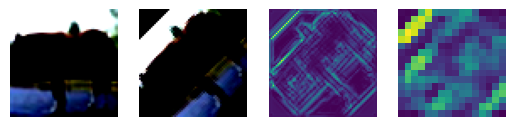

In [ ]:
plot_feature_map()